<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>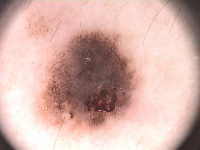</td><td>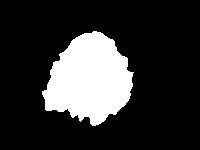</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [33]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=51f8d4cf-c364-426f-8c83-c86954e3a950
To: /kaggle/working/PH2Dataset.rar
100%|█████████████████████████████████████████| 162M/162M [00:00<00:00, 165MB/s]


In [34]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from PH2Dataset.rar

Program aborted




Would you like to replace the existing file PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp
1313366 bytes, modified on 2020-07-03 15:00
with a new one
1313366 bytes, modified on 2020-07-03 15:00

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [35]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [36]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [37]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

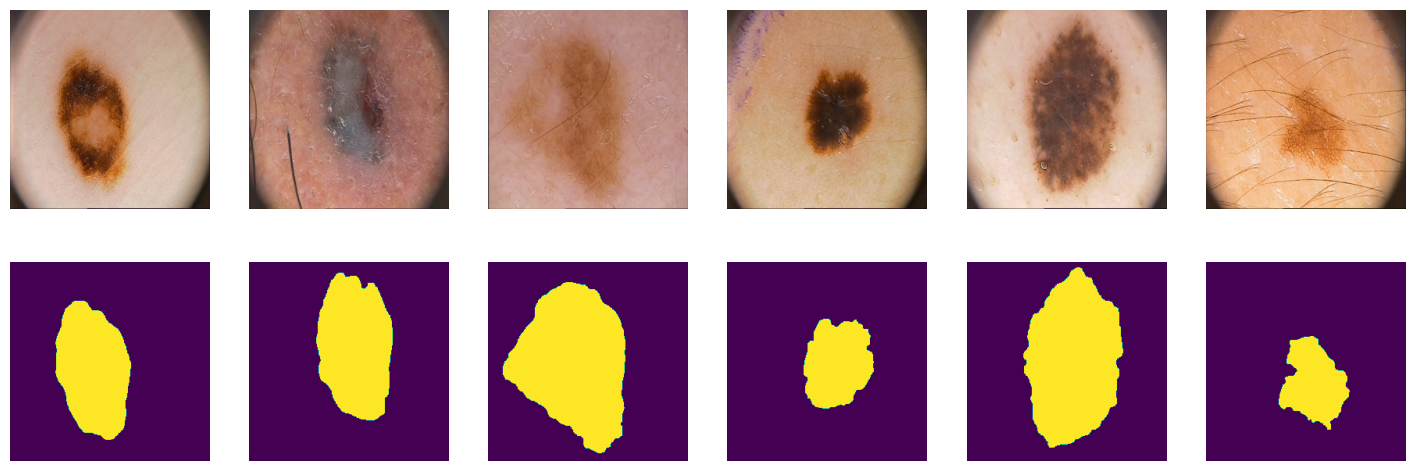

In [38]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [39]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [40]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [41]:
from torch.utils.data import DataLoader

batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [42]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [43]:
# !pip install torchmetrics

In [44]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)


# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

$$
\begin{align*}
&[1] = y \cdot -\log(\sigma(\hat{y})) + (1 - y) \cdot -\log(1 - \sigma(\hat{y})) \\
&= y \cdot -\log\left(\frac{1}{1 + e^{-\hat{y}}}\right) + (1 - y) \cdot -\log\left(\frac{e^{-\hat{y}}}{1 + e^{-\hat{y}}}\right) \\
&= y \cdot \log(1 + e^{-\hat{y}}) + (1 - y) \cdot \left(-\log(e^{-\hat{y}}) + \log(1 + e^{-\hat{y}})\right) \\
&= y \cdot \log(1 + e^{-\hat{y}}) + (1 - y) \cdot (\hat{y} + \log(1 + e^{-\hat{y}})) \\
&= (1 - y) \cdot \hat{y} + \log(1 + e^{-\hat{y}}) \\
&= \hat{y} - y \cdot \hat{y} + \log(1 + e^{-\hat{y}}) = [2]
\end{align*}

$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [45]:
import torch.nn.functional as F
import torch.nn as nn

In [46]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [47]:
def bce_loss(y_pred: torch.Tensor, y_real: torch.Tensor):
  return -(torch.sum(y_real * F.logsigmoid(y_pred)) + torch.sum((1-y_real)*torch.log(1 - torch.sigmoid(y_pred))))
  

def bce_true(y_pred: torch.Tensor, y_real: torch.Tensor):
  return torch.sum(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
  

Проверим корректность работы на простом примере

In [48]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.9255523681640625
BCE loss честно посчитанный = 5.925552845001221
BCE loss from torch bce_torch = 5.9255523681640625
BCE loss from torch with logits bce_torch = 5.925552845001221


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [49]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [50]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.806665420532227
BCE loss честно посчитанный = 13.80666446685791
BCE loss from torch bce_torch = 13.80666446685791
BCE loss from torch with logits bce_torch = 13.80666446685791


In [51]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [52]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 5.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.00MB/s]
Download completed


In [53]:
path_to_dummy_samples = './for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

/tmp/ipykernel_214/3257238461.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
/tmp/ipykernel

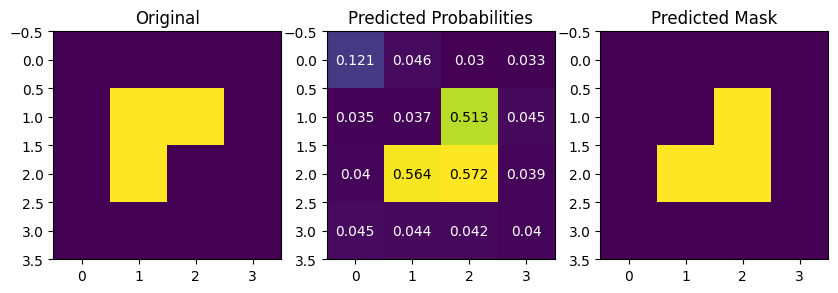

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [55]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())

assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

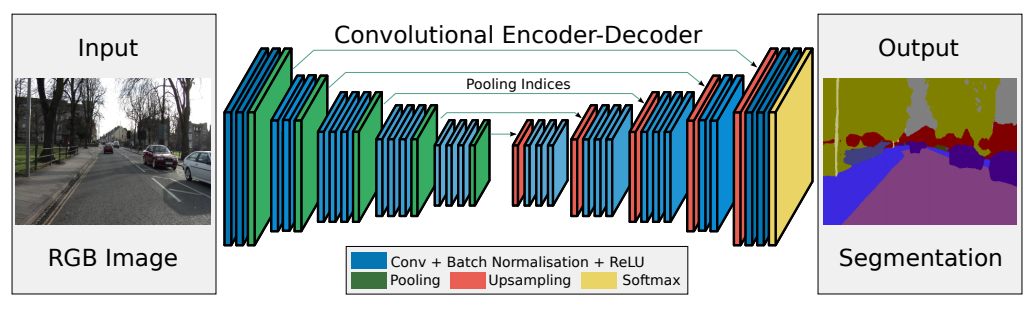

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time


from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


Ресурс на архитекутуру VGG16: https://www.digitalocean.com/community/tutorials/vgg-from-scratch-pytorch

In [57]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind
    

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x


class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # encoder VGG-16 architecture
        features = 64
        self.enc0 = EncoderBlock(in_channels, features, depth=2) # 64
        self.enc1 = EncoderBlock(features, features*2, depth=2) # 128
        self.enc2 = EncoderBlock(features*2, features*4, depth=3) # 256
        self.enc3 = EncoderBlock(features*4, features*8, depth=3) # 512

        # bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3) 
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3) 
        
        # decoder (upsampling)
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # No activation


    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        output = self.dec3(d2, ind0)  
        return output # no activation

In [58]:
segnet_model = SegNet()

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [59]:
import torch
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [60]:
from tqdm.notebook import tqdm

In [61]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in (train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss


def validate_single_epoch(model, criterion, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in (valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path):
    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')

    # Создаем tqdm progress bar для эпох
    pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    for epoch in pbar:
        # Обучение на одной эпохе
        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)
        # Валидация на одной эпохе
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device)

        # Сохраняем статистику
        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        # Сохраняем лучшую модель по валидационному лоссу
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/best_val_loss.pt')

        # Обновляем прогрессбар: добавляем информацию по текущей эпохе
        pbar.set_postfix({
            "Epoch": epoch + 1,
            "Train Loss": train_loss.item(),
            "Val Loss": val_loss.item(),
            "Val IoU": val_iou.item()
        })

    statistics = {
        'train loss': total_train_loss,
        'val_loss': total_val_loss,
        'val_iou': total_val_iou
    }
    return model, statistics



Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [62]:
model = segnet_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
epochs = 30

In [63]:
ckpt_path = './segnet_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [64]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [65]:

def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model = model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(Y_pred, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou

In [66]:
!ls segnet_checkpoints

best_val_loss.pt


In [67]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7473, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции.

1. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

In [68]:
!pip install segmentation-models-pytorch

Итак, давайте сначала пропишем dice_score.

In [69]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2*tp + eps) / (2*tp + fp + fn + eps)
    

    return score


Проверим на корректность функцию dice_score:

In [70]:
from torchmetrics.segmentation import DiceScore


dice_score(dummpy_sample['logits'].unsqueeze(0), dummpy_sample['labels'].to(int))
print(dice_score(dummpy_sample['logits'].unsqueeze(0), dummpy_sample['labels'].to(int)))

dice = DiceScore(num_classes=2, average="micro", input_format="one-hot").to(device)


dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')


tensor(0.6667, device='cuda:0')

In [71]:
assert dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [72]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    
    prob_mask = logits.sigmoid()

    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    loss = (2*tp + eps) / (2*tp + fp + fn + eps)

    return 1- loss

Проверка на корректность:

In [73]:
from segmentation_models_pytorch.losses import DiceLoss


dice_loss_torch = DiceLoss(mode='binary')
print(
    dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']))

dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')


tensor(0.5756, device='cuda:0')

In [74]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [75]:
import torch

def focal_loss(y_real: torch.Tensor, y_pred: torch.Tensor, gamma: float = 2.0) -> torch.Tensor:
    p = torch.sigmoid(y_pred)
    p_t = p * y_real + (1 - p) * (1 - y_real)
    focal_weight = (1 - p_t) ** gamma
    bce_loss = - (y_real * torch.log(p) + (1 - y_real) * torch.log(1 - p))
    loss = focal_weight * bce_loss
    return loss.sum()

print(focal_loss(dummpy_sample['labels'], dummpy_sample['logits']))

tensor(3.6161, device='cuda:0')


Проверка корректности функции:

In [76]:
from torchvision.ops import sigmoid_focal_loss

print(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'))
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'])

tensor(3.6161, device='cuda:0')


tensor(3.6161, device='cuda:0')

In [77]:
assert np.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').cpu(), focal_loss(dummpy_sample['labels'], dummpy_sample['logits']).cpu())

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Буду делать Tversky loss 

### Формула Tversky:
$$
\mathcal{T}(P, G; \alpha, \beta) = \frac{\sum_i p_i g_i}{\sum_i p_i g_i + \alpha \sum_i p_i (1 - g_i) + \beta \sum_i (1 - p_i) g_i}
$$

Где:
- $p_i$ — вероятность принадлежности к положительному классу (из softmax/sigmoid)
- $ g_i$ — бинарная маска (ground truth)
-  $\alpha, \beta$ — коэффициенты для контроля веса FP и FN


Смысл Tversky loss — это гибкая альтернатива Dice loss, позволяющая управлять балансом между precision и recall,


При $\alpha = \beta = 0.5$ является обычным Dice


In [78]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    
    prob_mask = logits.sigmoid()

    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    loss = (2*tp + eps) / (2*tp + fp + fn + eps)

    return 1- loss

In [79]:
import torch
import torch.nn as nn


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps  # для избежания деления на 0

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1).sigmoid()
        y_true = y_true.view(-1)

        TP = (y_pred * y_true).sum()
        FP = (y_pred * (1 - y_true)).sum()
        FN = ((1 - y_pred) * y_true).sum()

        tversky_index = (TP + self.eps) / (TP + self.alpha * FP + self.beta * FN + self.eps)
        return 1 - tversky_index


Должны совпадать 

In [80]:
print(dice_loss(dummpy_sample['logits'], dummpy_sample['labels']))

t_l = TverskyLoss()

t_l(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')


tensor(0.5756, device='cuda:0')

Совпадают

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



### Model Dice Loss

In [81]:
import torch

torch.cuda.empty_cache()

import gc

gc.collect()
torch.cuda.empty_cache()


In [82]:
segnet_model_dice_loss = SegNet().to(device)

model = segnet_model_dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = dice_loss_torch
epochs = 30

ckpt_path = './segnet_dice_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [83]:
model, statistics_dice = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [84]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7429, device='cuda:0')

### Model Focal Loss

In [85]:
segnet_model_focal_loss = SegNet().to(device)

from torchvision.ops import sigmoid_focal_loss


def focal_loss_fn(logits, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    return sigmoid_focal_loss(logits, targets, alpha=alpha, gamma=gamma, reduction=reduction)


model = segnet_model_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss_fn
epochs = 30

ckpt_path = './segnet_focal_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [86]:
model, statistics_focal = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [87]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7733, device='cuda:0')

### Model Tversky Loss

In [88]:
segnet_model_tversky_loss = SegNet().to(device)


model = segnet_model_tversky_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = TverskyLoss(0.6, 0.4)
epochs = 30

ckpt_path = './segnet_tversky_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [89]:
model, statistics_tversky = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [90]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7868, device='cuda:0')

### Картинки

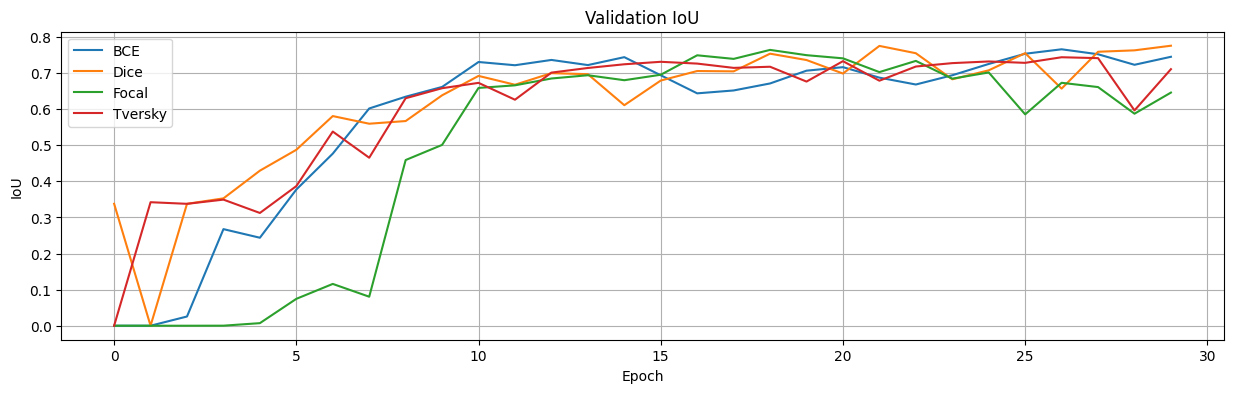

In [91]:
import matplotlib.pyplot as plt

# Словарь с подписями и данными
models_stats = {
    "BCE": statistics,
    "Dice": statistics_dice,
    "Focal": statistics_focal,
    "Tversky": statistics_tversky
}

# ---------- Plot: Validation IoU ----------
plt.figure()
for name, stats in models_stats.items():
    plt.plot(stats['val_iou'], label=name)
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()


## Выводы и ответы на вопросы

**При каком лоссе модель сходится быстрее?**

При Dice loss модель сходится быстрее всего. В целом, это понятно. Достаточно похожи Dice Loss и целевая метрика.


**При каком лоссе модель выдает наилучшую метрику?**

Везде примерно одинаково, однако для Tversky loss лучше всего показал себя на тесте.

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

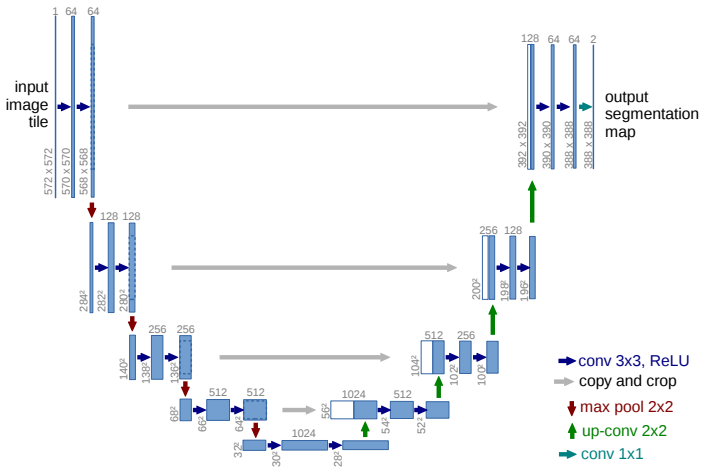

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [92]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [93]:
import torch
import torch.nn as nn

class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1):
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        feature_map = x  # Save feature map before pooling for skip connection
        x = self.pool(x)
        return feature_map, x

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, depth=2, kernel_size=3, padding=1):
        super(UNetDecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.layers.append(ConvReLU(out_c + skip_c, out_c, kernel_size, padding))
            else:
                self.layers.append(ConvReLU(out_c, out_c, kernel_size, padding))

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along channel dimension
        for layer in self.layers:
            x = layer(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        features = 64

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features, depth=2)  # 3 -> 64
        self.enc1 = EncoderBlock(features, features*2, depth=2)  # 64 -> 128
        self.enc2 = EncoderBlock(features*2, features*4, depth=3)  # 128 -> 256
        self.enc3 = EncoderBlock(features*4, features*8, depth=3)  # 256 -> 512

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvReLU(features*8, features*8),
            ConvReLU(features*8, features*8),
            ConvReLU(features*8, features*8)
        )  # 512 -> 512, depth=3

        # Decoder with skip connections
        self.dec0 = UNetDecoderBlock(features*8, features*8, features*4, depth=2)  # 512, skip 512 -> 256
        self.dec1 = UNetDecoderBlock(features*4, features*4, features*2, depth=2)  # 256, skip 256 -> 128
        self.dec2 = UNetDecoderBlock(features*2, features*2, features, depth=2)   # 128, skip 128 -> 64
        self.dec3 = UNetDecoderBlock(features, features, features, depth=2)       # 64, skip 64 -> 64

        # Final convolution
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)  # 64 -> 1

    def forward(self, x):
        # Encoder path
        fm0, e0 = self.enc0(x)   # Feature map 64
        fm1, e1 = self.enc1(e0)  # Feature map 128
        fm2, e2 = self.enc2(e1)  # Feature map 256
        fm3, e3 = self.enc3(e2)  # Feature map 512

        # Bottleneck
        b = self.bottleneck(e3)  # 512 channels

        # Decoder path with skip connections
        d0 = self.dec0(b, fm3)   # Upsample 512->256, cat with 512->768, conv to 256
        d1 = self.dec1(d0, fm2)  # Upsample 256->128, cat with 256->384, conv to 128
        d2 = self.dec2(d1, fm1)  # Upsample 128->64, cat with 128->192, conv to 64
        d3 = self.dec3(d2, fm0)  # Upsample 64->64, cat with 64->128, conv to 64

        # Output
        output = self.final_conv(d3)  # 64 -> 1
        return output  # Logits without activation

In [94]:
unet_model = UNet()
unet_model(next(iter(train_dataloader))[0])

tensor([[[[ 3.0874e-01,  1.8176e-01, -2.1150e-01,  ...,  2.0057e-01,
            5.9911e-01, -7.6402e-01],
          [-8.8032e-02,  2.8304e-01,  9.9642e-03,  ...,  2.1421e-01,
            6.6119e-01, -3.7413e-01],
          [-5.0395e-01, -3.3253e-01, -5.0799e-01,  ..., -6.3217e-01,
            7.3550e-02, -4.6466e-01],
          ...,
          [-4.8123e-01, -5.6376e-01, -3.7645e-01,  ...,  2.6995e-01,
           -2.3817e-01, -7.6749e-02],
          [-4.8826e-01, -1.3542e-01, -4.0990e-01,  ..., -4.4754e-01,
           -1.4248e+00,  1.5485e-01],
          [-1.0492e+00, -5.2609e-01, -2.4043e-01,  ...,  4.1546e-02,
           -7.6840e-01, -2.0147e-01]]],


        [[[ 3.9550e-01,  2.0380e-01, -1.4435e-01,  ...,  2.0520e-01,
            5.8486e-01, -8.0694e-01],
          [-1.0502e-01,  3.3073e-01,  2.8377e-01,  ...,  4.1069e-01,
            8.0547e-01, -2.3089e-01],
          [-4.7337e-01, -5.1517e-01, -5.0864e-01,  ..., -4.2888e-01,
            3.3372e-01, -4.1125e-01],
          ...,
   

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



### Model BCE Loss

In [95]:
unet_model_bce_loss = UNet().to(device)

model = unet_model_bce_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
epochs = 30


ckpt_path = './unet_bce_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 

In [96]:
model, statistics_unet_bce = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training: 100%|██████████| 30/30 [01:17<00:00,  2.59s/epoch, Epoch=30, Train Loss=2.55e+5, Val Loss=2.97e+5, Val IoU=0.803] 


In [97]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.8199, device='cuda:0')

### Model Dice Loss

In [98]:
unet_model_dice_loss = UNet().to(device)



model = unet_model_dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = dice_loss_torch
epochs = 30

ckpt_path = './unet_dice_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [99]:
model, statistics_unet_dice = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training: 100%|██████████| 30/30 [01:17<00:00,  2.59s/epoch, Epoch=30, Train Loss=0.111, Val Loss=0.143, Val IoU=0.776]


In [100]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7598, device='cuda:0')

### Model Focal Loss

In [101]:
unet_model_focal_loss = UNet().to(device)

from torchvision.ops import sigmoid_focal_loss


def focal_loss_fn(logits, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    return sigmoid_focal_loss(logits, targets, alpha=alpha, gamma=gamma, reduction=reduction)


model = unet_model_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss_fn
epochs = 30

ckpt_path = './unet_focal_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [102]:
model, statistics_unet_focal = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Training: 100%|██████████| 30/30 [01:17<00:00,  2.57s/epoch, Epoch=30, Train Loss=0.0142, Val Loss=0.0221, Val IoU=0.802]


In [103]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_214/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7640, device='cuda:0')

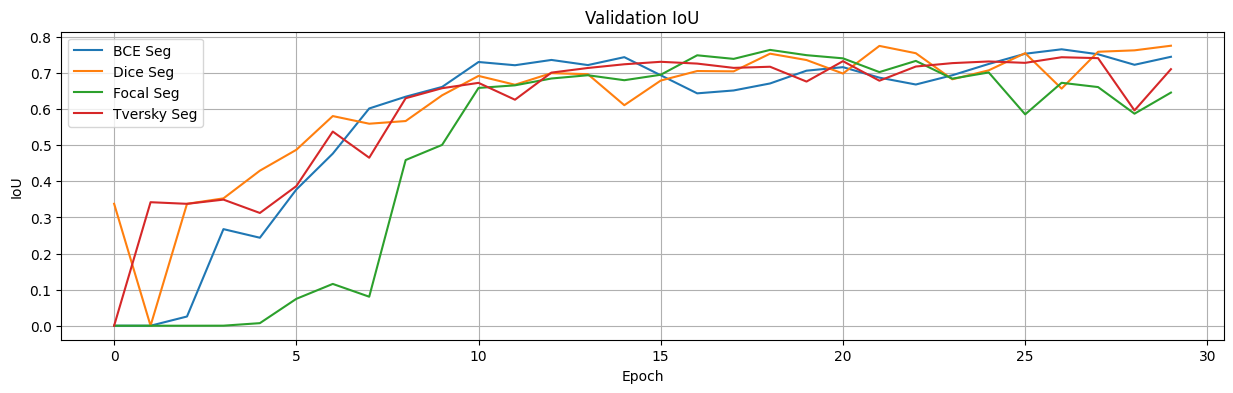

In [104]:
import matplotlib.pyplot as plt

# Словарь с подписями и данными
models_stats = {
    "BCE Seg": statistics,
    "Dice Seg": statistics_dice,
    "Focal Seg": statistics_focal,
    "Tversky Seg": statistics_tversky
}

# ---------- Plot: Validation IoU ----------
plt.figure()
for name, stats in models_stats.items():
    plt.plot(stats['val_iou'], label=name)
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()


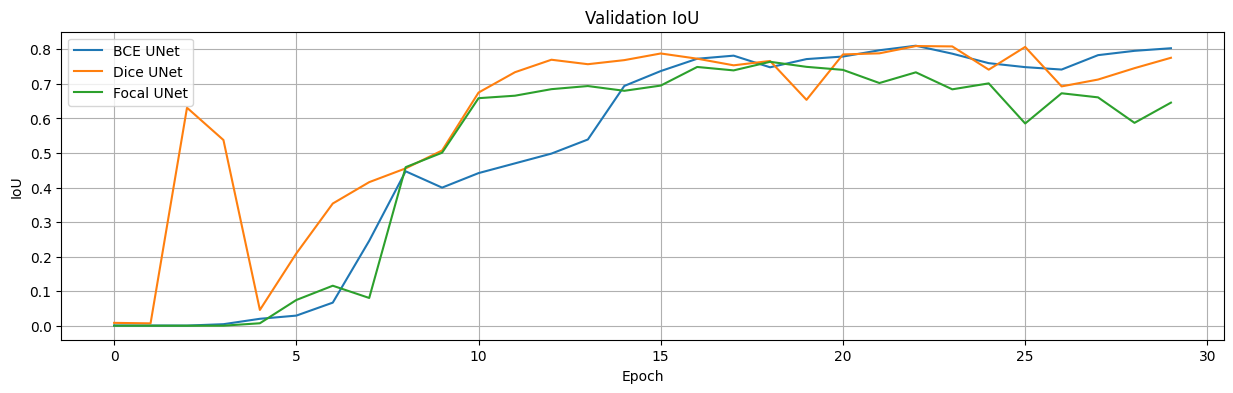

In [105]:
import matplotlib.pyplot as plt

# Словарь с подписями и данными
models_stats = {
    "BCE UNet": statistics_unet_bce,
    "Dice UNet": statistics_unet_dice,
    "Focal UNet": statistics_focal
}

# ---------- Plot: Validation IoU ----------
plt.figure()
for name, stats in models_stats.items():
    plt.plot(stats['val_iou'], label=name)
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()


## Выводы

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   **Какая модель дает лучшие значения по метрике?** 

    Лучше всего справился UNet с BCE loss

*   **Какая модель дает лучшие значения по лоссам?**

    Лучше всего справился UNet с BCE loss

*   **Какая модель обучается быстрее?**   

    Быстрее обучается SegNet, он быстрее достигает насыщения
*   Сравните визуально результаты SegNet и UNet.

    SegNet обучается быстрее, однако поскольку у него меньше информации на декодировщике, он меньшему может научиться,
    соответственно, быстрее достигает своего максимума. У UNet больше информации, поэтому обучается дольше и выдает результаты лучше 



